Task as Hand:
Your task is to use this data to model the AQI of Weber County on a daily, weekly, or monthly basis.
If you choose to aggregate the data into weekly or monthly values, you must justify the reason for doing so.

I will remove this sections, and the section headers instructions...

# Exploratory Data Analysis (EDA):
##### Provide insights into the dataset based on your initial analysis.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
df_2022 = pd.read_csv('../../datasets/daily_aqi_by_county_2022-2.csv')
df_2023 = pd.read_csv('../../datasets/daily_aqi_by_county_2023-1.csv')
df_2024 = pd.read_csv('../../datasets/daily_aqi_by_county_2024.csv') # This dataset differs from the one offered in the assignment since it seems like some dates got clipped.

# column 'AQI' is my target, and using the other column 'Date' as the series column I'll use time series regression techniques.
# df_2024.head(5)


In [219]:
# First I'll need to extract Only Utah from State Name, and Weber County from County Name.
# Filter for rows where State Name is 'Utah' and county Name is 'Weber'
df_2022_filtered = df_2022[(df_2022['State Name'] == 'Utah') & (df_2022['county Name'] == 'Weber')]
df_2022_filtered = df_2022_filtered.reset_index(drop=True)

df_2023_filtered = df_2023[(df_2023['State Name'] == 'Utah') & (df_2023['county Name'] == 'Weber')]
df_2023_filtered = df_2023_filtered.reset_index(drop=True)

df_2024_filtered = df_2024[(df_2024['State Name'] == 'Utah') & (df_2024['county Name'] == 'Weber')]
df_2024_filtered = df_2024_filtered.reset_index(drop=True)

# Keep only Date and AQI, convert Date to datetime, and set it as index
for df in [df_2022_filtered, df_2023_filtered, df_2024_filtered]:
    df.drop(columns=[col for col in df.columns if col not in ['Date', 'AQI']], inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# df_2022_filtered.info()
# df_2024_filtered
# print('df_2022 na check:\n', df_2022_filtered.isna().sum())
# print('df_2023 na check:\n', df_2023_filtered.isna().sum())
# print('df_2024 na check:\n', df_2024_filtered.isna().sum())

In [220]:
# Create visual-only copies with just Date, AQI, and Year
df_2022_vis = df_2022_filtered[['AQI']].copy()
df_2022_vis['Year'] = 2022

df_2023_vis = df_2023_filtered[['AQI']].copy()
df_2023_vis['Year'] = 2023

df_2024_vis = df_2024_filtered[['AQI']].copy()
df_2024_vis['Year'] = 2024

# Combine for visualization
df_vis_all = pd.concat([df_2022_vis, df_2023_vis, df_2024_vis])

# Convert Date and set index
# df_vis_all['Date'] = pd.to_datetime(df_vis_all['Date'])
# df_vis_all.set_index('Date', inplace=True)

print('Check for missing/na values:')
print(df_vis_all.isna().sum())



Check for missing/na values:
AQI     0
Year    0
dtype: int64


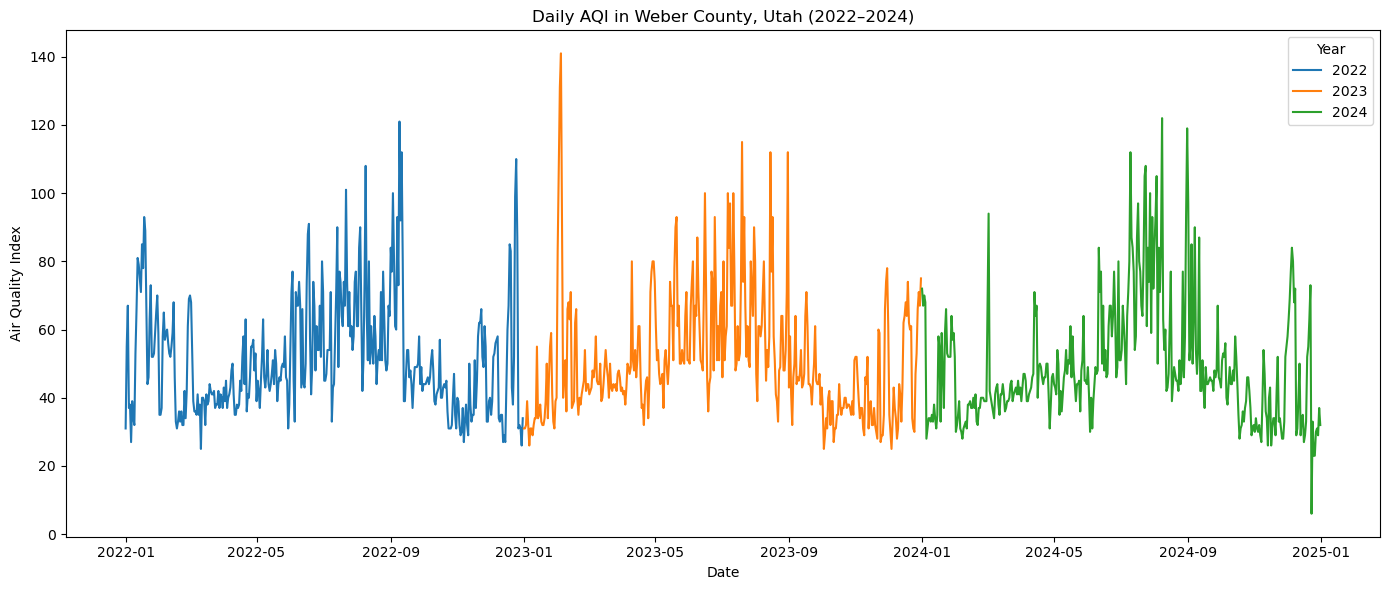

In [221]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_vis_all, x=df_vis_all.index, y='AQI', hue='Year', palette='tab10')
plt.title('Daily AQI in Weber County, Utah (2022–2024)')
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

There is a pattern each year showing that there is some seasonlity or trends in AQI.

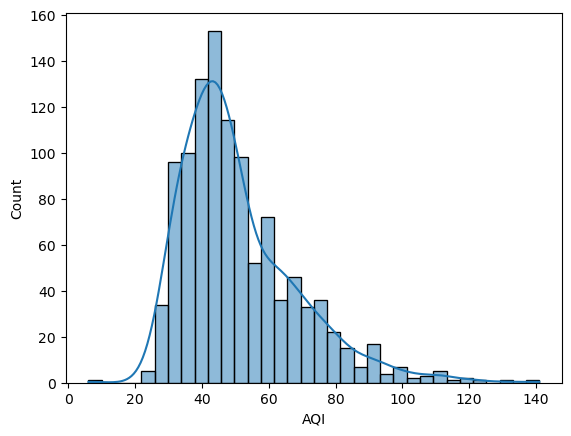

In [222]:
sns.histplot(df_vis_all['AQI'], kde=True);

# Reason for Aggregation (if applicable):
<h5>Explain why you chose to aggregate the data (or not), and describe how you performed this aggregation if it applies.</h5>

In [223]:
#todo

# Transformations:
<h5>Discuss whether you applied any transformations (e.g., log, square root) to the data and why, or explain why no transformation was needed.</h5>

In [224]:
# todo

# Seasonal Patterns:
<h5>Identify any seasonal patterns in the AQI data. If no seasonality is present, provide visualizations to support this conclusion.</h5>

In [225]:
# todo

# Autocorrelation:
<h5>Analyze significant autocorrelations in the data and explain any patterns observed in the lag values.</h5>

In [226]:
# todo

# Correlation Coefficients:
<h5>Calculate correlation coefficients for selected lag values and provide scatter plots to visualize these relationships.</h5>

In [227]:
# todo

# Data Splitting:
<h5>Split the data, using the last 12 values for model testing.</h5>

In [228]:
# todo

# Model Selection:
<h5>Try different models and describe the criteria used to select your final model.</h5>

In [229]:
# todo

# Model Parameters and Diagnostics:
<h5>Explain the statistical significance of the model parameters and any diagnostic tests performed to validate the model.</h5>

In [230]:
# todo

# Final Model Equation:
<h5>Present the equation of your final model.</h5>

In [231]:
# todo

# Forecasting:
<h5>Forecast the AQI for the last 12 values, including confidence intervals.</h5>

In [232]:
# todo

# Model Performance:
<h5>Compute the error of the model’s performance on the test data.</h5>

In [233]:
# todo

# Conclusion:
<h5>Summarize your findings and reflect on the forecasting accuracy and the AQI trends observed.</h5>

In [234]:
# todo